# ASSIGNMENT 3                                                McGill COMP451
Archive of my solution to this assignment.
The task was to train a neural-net to recognize the digits 1-4 that had been superimposed with an xor, rotated, and then had noise applied.

My solution was to implement arXiv:2211.11812, which describes a rotationally invariant convolution. A standard convolution is rotationally invariant because the kernel is translated across the entire image, so the exact same operation is applied to pixels no matter how they are placed in the image. Here, instead, a kernel is rotated about the center of an image, so that the same operation would be applied to pixels no matter how far away from, or their position around the origin. A more detaled explanaiton of the math can be found in the comments of the code below. 

## Step 1 - the dataset
Use the following code to load the data using the npy files. We have 11,000 training examples, where each image is 64x64. Each image contains two digists $A,B \in \{1,2,3,4\}$, and the label is the product of numbers in each image $A \times B$. The label is printed at the top of each example shown below.

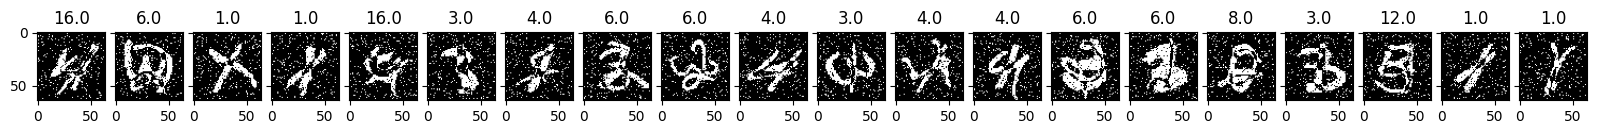

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid    
import torch as t      
device = t.device('cuda' if t.cuda.is_available() else 'cpu') 
              #To plot the images in grid and we have seen it befoer 

x = np.load('datasets/x_train.npy') #11,000 x 64 x 64
y = np.load('datasets/y_train.npy')

x = x.astype(np.float32)
y = y.astype(np.float32)
x_t = t.from_numpy(x).to(device)[:, None, :, :]

def plot_digits(x,y):
    num_plots = x.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(x[i].reshape((64,64)),cmap='gray')
        grid[i].set_title(str(y[i]))
    plt.show()
plot_digits(x[:20], y[:20])  #plot 20 first instances in the dataset 

## Step 2 - preprocessing 

Your report should contain any potential preprocessing that you have done on the dataset. If you haven't performed any preprocessing, please leave this empty. This includes any sample code that you will use. 

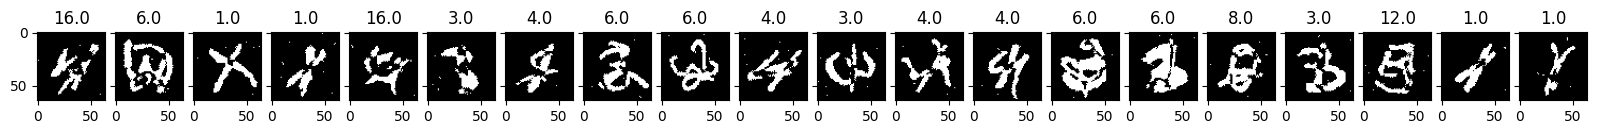

In [18]:
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader



def to_hot(x):
    z = np.zeros(9)
    match x:
        case 1:
            z[0] = 1
        case 2:
            z[1] = 1
        case 3:
            z[2] = 1
        case 4:
            z[3] = 1
        case 6:
            z[4] = 1
        case 8:
            z[5] = 1
        case 9:
            z[6] = 1
        case 12:
            z[7] = 1
        case 16:
            z[8] = 1
    return z

def to_label(x):
    match x:
        case 1:
            return 0
        case 2:
            return 1
        case 3:
            return 2
        case 4:
            return 3
        case 6:
            return 4
        case 8:
            return 5
        case 9:
            return 6
        case 12:
            return 7
        case 16:
            return 8
        
def labels(y):
    return np.array([to_label(x) for x in y])

def onehot(y):
    return np.array([to_hot(x) for x in y])

y_hot = t.from_numpy(labels(y)).to(t.long)


ker_3 = t.tensor([[[[.5,1,.5],[1,0,1],[.5,1,.5]]]], dtype=t.float32).to(device)

def denoise(x):
    # idea: perform a convolution equivalent to the "count neighbors" operation, and then, if 3 or less, kill. If 7 or 8, lives.
    value = t.tensor([1.]).to(device)
    mask = F.conv2d(x, ker_3, padding=1)
    mask = t.heaviside(mask - 255.*3, value)
    return mask

x_denoise = denoise(x_t)
plot_digits(x_denoise[0:20, 0], y)


validation_dataset = TensorDataset(x_denoise[9900:],y_hot[9900:])
validation_dataloader = DataLoader(validation_dataset)

training_dataset = TensorDataset(x_denoise[0:9900],y_hot[0:9900])
training_dataloader = DataLoader(training_dataset)

# Step 3 - the model and its training
This is the main part of your report. Below we provide an example, where we apply a logistic regression model to the dataset, and we get a very bad accuracy. You can do much better! You also have to use a deep learning package in your solution. Provide the explanation for your model and its training below. 

## 3.1 example code (not using pyTorch)
The code below shows the performance of a logistic regression model which will be used as a base model in this case. 

In [483]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
features = x.reshape(11000,-1) #vectorizing the input image
labels = y.reshape(-1,1)
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.33, random_state=42) #set aside 33% of the data for validation
clf = LogisticRegression()
clf.fit(x_train,y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("The validation accuracy of the model is", accuracy*100, '%')

ModuleNotFoundError: No module named 'sklearn'

## 3.2 your model!

 You should choose the final learning model that you have used to submit your solutions to Kaggle. For your chosen model provide the implementation code in this notebook along with the detail. Details should include the architecture and the choice of hyperparameters. If you performed a hyperparameter search you should explain it here.

you can start here in the same cell!


In [13]:
## your implementation goes here!

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torchvision

t.set_default_tensor_type('torch.cuda.FloatTensor' if t.cuda.is_available() else "torch.FloatTensor")
from typing import List
# a single layer module, performs a rotationally invariant "convolution" rather than the traditional translationally invariant one.
# defined in arXiv:2211.11812, code my own
# RICC = Rotationally Invariant Coordinate Convolution
# RICS = Rotationally Invariant Coordinate Sytem




# very high-level version of the paper: traditional convolution is translation-invariant because it slides a square around a rectangular image.
# its fairly intuitive to see why this is the case, the same operation is done with the same values to every pixel

#a RICS allows us to rotate a circular kernel around the origin. Each weight is pushed so that the "first" (top left)
# weight in the kernel is always the farthest from the origin., and (in my implementation) the second (top middle) is 45deg counterclockwise
# from the perspective of the origin from that, and they repeat untill a ring is formed. The resultant network is no longer 
# translationally invariant, but is rotationally invariant.
# this claim is proven in the cited paper, and some pictures make the argument very clear and intuitive.
def gen_RICS(size: int, ks: int = 3):
    #x an y offsets for each piece of the kernel. would need to be more complex to support ks > 3

    # in order to keep even-sized images even, we first make them odd, the center is zeros, later they are removed if even.
    is_even = (size + 1) % 2
    size = size + is_even

    x_0 = t.arange(np.ceil(-size/2), np.ceil(size/2))
    X = t.zeros(size, size, 2)
    

    # generate a tensor, where each entry in the tensor is the coordinates of that pixel
    # there's a cleaner way to do all of this im sure, but this works and only needs to run a couple of times in the very beginning
    X[:, :, 0] = x_0
    X = X.transpose(1, 0)
    X[:, :, 1] = x_0.flip([0])
    # each entry of the tensor is the coordinate of the pixel, shape = (size, size, 2) -- [y, x]
    X = X.transpose(1, 0)

    
    if (is_even): 
        size = size - is_even
        middle = int(size/2)
        X = t.cat((X[:middle], X[middle + 1:]))
        X = X.transpose(1, 0)
        X = t.cat((X[:middle], X[middle + 1:]))
        X = X.transpose(1, 0)
        
    # phi := angles from origin to each point. The farthest point from the origin is the "first" in our list of weights
    phi = t.atan2(X[:, :, 0], X[:, :, 1])
    phi = phi.transpose(1, 0)[:, :, None]


    r = 1
    Q = t.zeros(size, size, 2, ks * ks)
  # phi         size, size, -,  1,  1
    i = t.arange(ks * ks)

    # later in development, I discovered that when performing an offset-convolution, the offset coordinates are stored in y,x, y_2,x_2
    # no clue why, but this is why it's sin then cos, not cos then sin

    # Q here is our rotationally invariant coord system
    Q[:, :, 1] = (r * t.cos(phi + i * 2 * t.pi / (8 * r)))
    Q[:, :, 0] = (r * t.sin(phi + i * 2 * t.pi / (8 * r)))


    Q = Q.transpose(2,-1).reshape(size,size, 2*(ks*ks))


    # magic numbers that came from a lot of experimentation. If all nine points of a kernel were 
    # in the center of the kernel by default, these offsets would put them in the usual 3x3 arrangement
    # in otherwords, a defconv2d with -points as the offsets would be equivalent to a 1x1 kernel
    points = t.tensor([-1,-1. ,-1,0, -1,1,  0,-1, 0,0, 0,1,  1,-1, 1,0, 1,1,])
    if ks == 1:
        points = t.tensor([0, 0])
    
    # the nineth pair of each list is reserved for the center. No real reason for this other than ease of use.
    # so the first eight points in every entry of Q form a ring around the center one, and then the center one is 
    # 0, 0, completing the little circle
    Q[:, :, -2:] = 0.


    X = X[:, :, :, None].expand(-1, -1, -1, ks*ks).transpose(2,-1).reshape(size,size, 2*(ks*ks))
    return (X + Q) - (X + points)


c:\Users\milto\OneDrive\Projects\A3 Comp400\venv\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


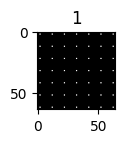

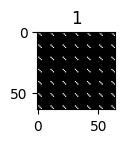

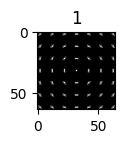

In [14]:

class RICC(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int =3,
                 stride=1,
                 padding=1,
                 bias=False):
        super(RICC, self).__init__()
        
        self.stride = stride
        self.padding = padding
        
        self.rics = None
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = t.nn.parameter.Parameter(
            t.empty(out_channels, in_channels, self.kernel_size, self.kernel_size)
        )
        


    def forward(self, x):
        if self.rics == None:
            self.rics = gen_RICS(x.shape[-1], self.kernel_size).expand(x.shape[0], -1, -1, -1).transpose(1, -1)

        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=self.rics,
                                          weight=self.weight,
                                          stride=self.stride,
                                          padding=self.padding)
        return x


input = x_denoise[1]
input = input[None, :, :, :]
input = t.zeros(1, 1, 64, 64)
input[:, :, 2::10, 2::10] = 1
#input[:, :, :, ::10] = 1




kh, kw = 3, 3
weight = t.zeros(1, 1, kh, kw)
weight[:, :] = t.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

#offset = t.tensor([-1,-1. ,-1,0, -1,1,  0,-1, 0,0, 0,1,  1,-1, 1,0, 1,1,])[None, :, None, None].expand(-1, -1, 64, 64)
ric = gen_RICS(64)[None, :, :, :].transpose(1, -1)
out = F.conv2d(input, weight, padding=1)
out_ricc = torchvision.ops.deform_conv2d(input, ric, weight, padding=1)
plot_digits(input[0], [1])
plot_digits(out[0], [1])
plot_digits(out_ricc[0], [1])


In [15]:
# model structure defined and explained in arXiv:1608.06037, code adapted from their implementation, comments are my own 
class SimpleNet(nn.Module):
    # parameters of layers forward to back (this is the simpleist, and already works on mnist)
    def __init__(self):
        super(SimpleNet, self).__init__()
        # layer, stride, default_dropout_rate *layer type
        simplenet_config = [
            (64, 1, 0.1),
            (32, 1, 0.1),
            (32, 1, 0.1),
            (32, 1, None),
            ("p", 2, 0.1),
            (32, 1, 0.1),
            (32, 1, 0.1),
            (64, 1, None),
            ("p", 2, 0.1),
            (64, 1, 0.1),
            (64, 1, None),
            ("p", 2, 0.1),
            (128, 1, 0.1),
            (256, 1, 0.1, "k1"), #default is k3
            (64, 1, None, "k1"),
            ("p", 2, 0.1),
            (64, 1, None),
        ]
        input_channel = 1

        layers: List[nn.Module] = []
        
        for (layer, stride, dropout_rate, *layer_type) in simplenet_config:
            kernel_size = 3
            padding = 1 
            if layer_type == ['k1']:
                kernel_size = 1
                padding = 0 

            if layer == "p":
                layers += [
                    nn.MaxPool2d(kernel_size=(2, 2), stride=(stride, stride)),
                    nn.Dropout2d(p=dropout_rate, inplace=True),
                ]
            else:
                filters = round(layer)
                #zero dropout rate causes a crash in some versions of pyTorch, at least according to stackoverflow
                #   this crash is apparently rare and can happen deep into training, so obviously avoided here, but
                #   yes, in an ideal world, the config would just state dropout of zero. 
                if dropout_rate is None:
                    layers += [
                        RICC(input_channel, filters, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.BatchNorm2d(filters, eps=1e-05, momentum=0.05, affine=True),
                        nn.ReLU(inplace=True),
                    ]
                else:
                    layers += [
                        RICC(input_channel, filters, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.BatchNorm2d(filters, eps=1e-05, momentum=0.05, affine=True),
                        nn.ReLU(inplace=True),
                        nn.Dropout2d(p=dropout_rate, inplace=False),
                    ]

                input_channel = filters

        model = nn.Sequential(*layers)
        for m in model.modules():
            if isinstance(m, RICC):
                nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))

        self.features = model
        self.classifier = nn.Linear(64, 9)

    def forward(self, x):
        x = self.features(x)

        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = F.dropout2d(x, 0.1)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [16]:

loss_fn = nn.CrossEntropyLoss()

model = SimpleNet()
optimizer = t.optim.SGD(model.parameters(), lr=0.001)

#loss function feed integers, feed true target values
# 

In [19]:



#taken from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/digits_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with t.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        t.save(model.state_dict(), model_path)

    epoch_number += 1

KeyboardInterrupt: 

# Step 4 - accuracy metrics and CSV submission to Kaggle

Here you can report accuracy metrics for the training and test sets. If you set aside a validation set you can report your accuracy on that set. Other plots such as training-validation loss plot over the training period can also be interesting to see here. A minimum here is the accuracy on the first half of the test set. **this number should match your public leaderboard accuracy**. **If this is not the case then your predictions here do not match what you reported on Kaggle and your submission is discarded!** This is because otherwise we can't establish that this code was used to produce the result of the leaderboard. Below we show this minimal report for the logistic regression classifier that we trained above.

In [106]:
x_test = np.load('datasets/x_test.npy') #9,000 x 64 x 64
x_test_half = x_test[:4500] #the first half for which you have the true labels
y_test_half = np.load('datasets/y_test.npy') #length 4,500: you only have the true lable for the first half of the dataset 

predictions = clf.predict(np.reshape(x_test_half, (4500,-1)))
accuracy = accuracy_score(y_test_half, predictions)
print("The accuracy of the model that should match the public leaderboard accuracy is", accuracy*100, '%')


NameError: name 'clf' is not defined

In [119]:
# >>> your code printing the test error on x_test_half
x_test = np.load('datasets/x_test.npy') #11,000 x 64 x 64
y_test = np.load('datasets/y_test.npy')

y_hot_test = t.from_numpy(onehot(y_test))

x_denoise_test = denoise(x_test[4500:])

print(x_denoise_test.shape, y_hot_test.shape)
test_dataset = TensorDataset(x_denoise_test,y_hot_test)
test_dataloader = DataLoader(test_dataset)

to_product = [1, 2, 3, 4, 6, 8, 9, 12, 16]

t_outputs = np.zeros(y_hot_test.shape[0])
with t.no_grad():
    for i, tdata in enumerate(test_dataloader):
        tinputs, tlabels = tdata
        toutputs_batch = model(tinputs)
        t_outputs[i] = to_product[np.argmax(toutputs_batch)]

print(t_outputs.shape)
accuracy = np.average(t_outputs == y_test)
print("The accuracy of the model that should match the public leaderboard accuracy is", accuracy*100, '%')


# <<< your code here

torch.Size([4500, 1, 64, 64]) torch.Size([4500, 9])
(4500,)
The accuracy of the model that should match the public leaderboard accuracy is 11.866498765432098 %


In order to submit your results to Kaggle you need to provide your predictions in CSV format. The code below shows how we do this for the example of logistic regression above. You can use the same method for your submission. Note that we need you to submit your result for the **entire test set** of size 9000. Your accuracy on the first half will show on the public leaderboard and the second half is on the private leaderboard that will be revealed when the competition is over. Submit the `predicted_labels.csv` to the Kaggle competition!  

In [123]:
import pandas as pd #you need to install pandas - also checkout what this package is good for while at it :]
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels.csv',index=False)
    pass

yh_test = clf.predict(np.reshape(x_test, (9000,-1))) #prediction of the model for the entire test set
generate_csv_kaggle(yh_test)

NameError: name 'clf' is not defined

In [12]:
import pandas as pd #you need to install pandas - also checkout what this package is good for while at it :]
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels.csv',index=False)
    pass

x_test = denoise(np.load('datasets/x_test.npy')) #4,500 x 64 x 64
y_test = np.load('datasets/y_test.npy')
model = SimpleNet()
model.load_state_dict(t.load('model_20231124_150418_4'))
print(x_test.shape)
with t.no_grad():
    y_predict = model(x_test)
generate_csv_kaggle(y_predict)


torch.Size([9000, 1, 64, 64])


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 9437184000 bytes.